# Total Variation Image Segmentation
#### From: Chan, T. F., & Vese, L. A. (2001). Active contours without edges. *IEEE Transactions on image processing, 10*(2), 266-277.

Let $u_0$ be an image with two distinct regions of constant (but differing between them) intensities. It is important to note that each region can be composed of one or more connected components. One of these regions is the object to be segmented and the other is the background. Let $C_0$ denote the boundary of the object and let $C$ be any other variable curve.

Our goal now is to minimize the energy $F(C, c1, c2)$:
$$
F(C, c1, c2) = \mu\cdot(\text{length}(C)) + \nu\cdot\text{area}\,(\text{inside}(C)
+ \lambda_1\int_{\text{inside}(C)} |u_0 - c_1|^2 \, dx\,dy
+ \lambda_2\int_{\text{outside}(C)} |u_0 - c_2|^2 \, dx\,dy.
$$
Now we formulate the problem in terms of level sets. We let our curve $C$ be represented by the zero level set of a Lipschitz function $\phi : \mathbb{R}^n \rightarrow \mathbb{R}$, such that:
\begin{align*}
C = \big\{ (x,y) : \phi(x,y) = 0 \big\} \\
\text{inside}(C) = \big\{ (x,y) : \phi(x,y) > 0 \big\} \\
\text{outside}(C) = \big\{ (x,y) : \phi(x,y) < 0 \big\}.
\end{align*}
In simpler terms, $\phi(x,y)$ defines a kind of surface (when viewed in 3-D space) and the curve which "performs" the segmentation is the intersection of this surface with the plane $xy$-plane. Inside the curve, the "inside" of the curve is where the surface lays above the $xy$-plane, while the "outside" of the curve is where the surface lays beneath said plane.

With this formulation we can write the energy $F(\phi, c1,c2)$ as:
$$
F(\phi,c1,c2) = \mu \Big( \int_\Omega \delta(\phi)|\nabla \phi| \Big) + \nu\int_\Omega H(\phi) \,dx\,dy +
\lambda_1 \Big( c_1^2 \int_\Omega H(\phi) \, dx\,dy - 2c_1 \int_\Omega u_0 H(\phi) \, dx\,dy + \int_\Omega u_0^2 H(\phi) \,dx\,dy \Big) +
\lambda_2 \Big( c_2^2 \int_\Omega \big(1 - H(\phi)\big) \, dx\,dy - 2c_2 \int_\Omega u_0 \big( 1 - H(\phi) \big) \, dx\,dy + \int_\Omega u_0^2 \big( 1 - H(\phi) \big) \,dx\,dy \Big),
$$
where $H$ and $\delta$ are the Heaviside function and Dirac measure concentrated at 0:
$$
H(z) = \begin{cases}
      1 \:\:, \text{ if }z \geq 0 \\
      0 \:\:, \text{ if }z < 0
\end{cases} \:\:\:,\:\:\: 
\delta(z) = \frac{d}{dz}H(z).
$$
Now if we fix $\phi$ and minimize with respect to $c_1$ and $c_2$ we find that:
$$
c_1(\phi) = \frac{\int_\Omega u_0 \big(1- H(\phi)\big)\,dx\,dy}{\int_\Omega \big(1- H(\phi)\big)\,dx\,dy}
\:\:\: , \:\:\: c_2(\phi) = \frac{\int_\Omega u_0 \big(1- H(\phi)\big)\,dx\,dy}{\int_\Omega \big(1- H(\phi)\big)\,dx\,dy} \tag{1}
$$
Computing the Euler-Lagrange equations for the function $\phi$ yields the following gradient descent direction:
\begin{align*}
\frac{\partial\phi}{\partial t} = \delta_\varepsilon(\phi) \bigg[ \mu \Big(\nabla\cdot\big( \frac{\nabla\phi}{|\nabla\phi|} \big) \Big) -\nu - \lambda_1(u_0-c_1)^2 + \lambda_2(u_0-c_2)^2 \bigg] & \, , \text{ in } \Omega \tag{2} \\
\Big( \int_\Omega \delta_\varepsilon(\phi) |\nabla\phi| \Big) \, \cdot \frac{\delta_\varepsilon(\phi)}{|\nabla \phi|}\frac{\partial\phi}{\partial n} = 0 \, & , \text{ in }\partial ω,
\end{align*}
where $\delta_\varepsilon = H'_\varepsilon$ and $H_\varepsilon$ are regularizations of $\delta$ and $H$. In this notebook, the regularizations taken are:
\begin{align*}
H_\varepsilon(z) & = \begin{cases}
                    1\,,\text{ if } z>\varepsilon \\
                    0\,,\text{ if } z<-\varepsilon \\
                    (1/2)\big( 1+\frac{z}{\varepsilon} + \frac{1}{\pi}\sin\frac{\pi z}{\varepsilon} \big)\,,\text{ if } |z|\leq \varepsilon \\
\end{cases} \:\:,\:\: \tag{3}  \\
\delta_\varepsilon(z) & = \begin{cases}
                        0 \,,\text{ if } |z|>\varepsilon \\
                        \frac{1}{2\varepsilon}\Big[ 1+\cos\big( \frac{\pi z}{\varepsilon} \big) \Big] \,, \text{ if} |z|\leq\varepsilon \tag{4}
\end{cases}
\end{align*}
$c_1$ and $c_2$ are also calculated using these regularizations.

The $\phi$ function used in this notebook is defined as follows:
$$
\phi(x,y) = -\sqrt{(x-M/2)^2 + (y-N/2)^2} + M/2,
$$
where $M$ and $N$ are the horizontal and vertical dimensions of the image domain, respectively and $(M/2), (N/2)$ should be rounded in the implementation in order to avoid any numerical error.

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

In [18]:
# This function defines H as given in (3)

def H(phi, epsilon=1):
    arr = 0.5*(1 + (2 / np.pi)*np.arctan(phi/epsilon))
    return(arr)

In [19]:
# Similarly, define delta as given in (4)

def delta(phi, epsilon=1):
    arr = np.where(np.abs(phi) > epsilon, 0, (1/(2*epsilon))*(1+np.cos(phi*np.pi/epsilon)))
    return(arr)

In [20]:
# The following two functions help calculate c1 and c2 as in (1)

def c1(u0, phi):
    num=np.sum(u0*H(phi))
    den=np.sum(H(phi))
    return num/den

def c2(u0, phi):
    num=np.sum(u0*(1-H(phi)))
    den=np.sum(1-H(phi))
    return num/den

In [21]:
# This function makes the phi function given an initial image u0

def makePhi(u, s=0):
    M,N = u.shape

    phi = np.zeros((M,N))
    for x in range(M):
        for y in range(N):
            phi[x,y] = -np.sqrt((x - round(M/2))**2 + (y - round(N/2))**2) + round(M/2)  # phi is made
    phi=phi/np.max(phi)
    return phi

In [22]:
# This function simply helps in calculating the divergence term that shows up in (2)

def divergence(phi, delta=0.000001):    # delta is a small term used to avoid division by 0
    grad_phi = np.gradient(phi)
    grad_phi = grad_phi/ (np.sqrt(grad_phi[0]**2 + grad_phi[1]**2 + delta) ) # divide by the norm of the gradient
    phi_x = grad_phi[0]
    phi_y = grad_phi[1]                  # ux and uy are the first partial derivatives
    phi_xx = np.gradient(phi_x)[0]
    phi_yy = np.gradient(phi_y)[1]        # uxx and uyy are the second partial derivatives
    div = phi_xx + phi_yy
    return(div)

In [23]:
# The following function calculates the next phi

def nextIteration(u0, phi_k, mu, nu, lambda1, lambda2, dt, s):
    M, N = phi_k.shape
    C1 = c1(u0, phi_k)
    C2 = c2(u0, phi_k)
    GRAD = mu*(divergence(phi_k)) - nu - lambda1*(u0-C1)**2 + lambda2*(u0-C2)**2
    phi_new = phi_k - dt*GRAD
    return(phi_new)

In [24]:
# This function performs the gradient descent process while drawing each iteration of it

def gradientDescent(u0, mu, nu, lambda1, lambda2, dt, s, N_iter):
    phi_k = makePhi(u0)
    plt.clf();
    plt.imshow(u0, cmap='gray'),plt.xticks([]), plt.yticks([]);
    plt.contour(phi_k,[0],colors = 'red'); 
    plt.show(block=False),plt.pause(0.01);
        
    for i in range(N_iter):
        print("iteration: ", i)
        phi_k = nextIteration(u0, phi_k, mu, nu, lambda1, lambda2, dt, s)
        plt.clf();
        plt.imshow(u0, cmap='gray'),plt.xticks([]), plt.yticks([]);
        plt.contour(phi_k,[0],colors = 'red'); 
        plt.show(block=False),plt.pause(0.01);
    return(phi_k)

In [32]:
# Define parameters and hyperparameters

mu = 0.003 * 255 * 255
nu = 0
lambda1 = 1
lambda2 = 1
dt = 0.01
N_iter = 5
s = 0.000001

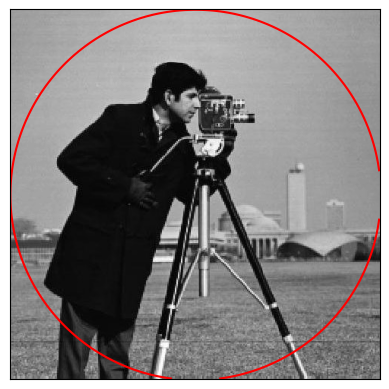

iteration:  0


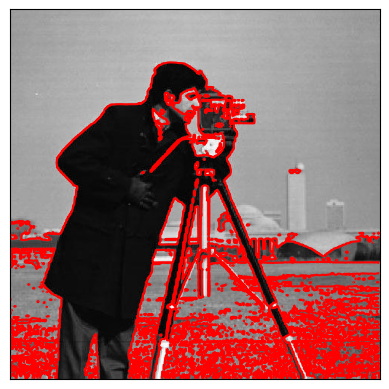

iteration:  1


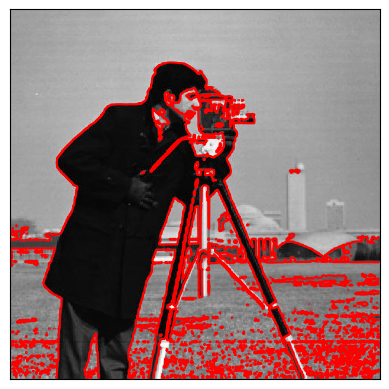

iteration:  2


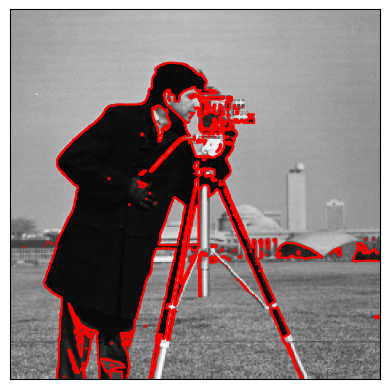

iteration:  3


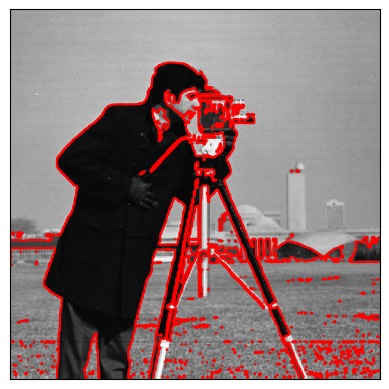

iteration:  4


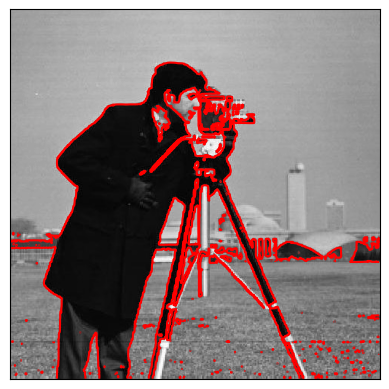

In [33]:
# Read the image
img_matrix = np.array(Image.open("cameraman.jpg").convert('L'))

# Perform the gradient descent and save to a new variable
segmented = gradientDescent(img_matrix, mu, nu, lambda1, lambda2, dt, s, N_iter)